In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled)


In [2]:
%matplotlib inline
import utils_modified; reload(utils_modified)
from utils_modified import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.engine.topology import Merge

In [4]:
model_path = '../data/imdb/models/'

In [5]:
from keras.datasets import imdb
idx = imdb.get_word_index()

In [6]:
idx_arr = sorted(idx, key=idx.get)
idx_arr[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i']

In [7]:
len(idx_arr)

88584

In [8]:
idx2word = {v: k for k, v in idx.iteritems()}

In [9]:
n = 5
(idx2word[n], idx[idx2word[n]])

('to', 5)

In [10]:
path = get_file('imdb_full.pkl',
                origin='https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
                md5_hash='d091312047c43cf9e4e38fef92437263')
f = open(path, 'rb')
(x_train, labels_train), (x_test, labels_test) = pickle.load(f)

In [11]:
# x_train contains lists of variable length were words are represented by indices
len(x_train[0]), len(x_train[1]), len(x_train[2])

(138, 433, 149)

In [12]:
wrds = [idx2word[n] for n in x_train[0]]
' '.join(wrds)

"bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell high's satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers' pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector i'm here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn't"

In [13]:
vocab_size = 2500
#wvect_dims = 32
maxlen = 500

In [14]:
def paddedset(orig_set):
    adj_set = [[min(n,vocab_size-1) for n in sq] for sq in orig_set]
    return pad_sequences(adj_set, maxlen=maxlen, dtype='int32', padding='pre', truncating='post', value=0)

In [15]:
x_train_pad = paddedset(x_train)
x_test_pad = paddedset(x_test)

In [16]:
print(len(x_train[0]))
print(x_train[0][0:8])
print([n for n in x_train_pad[0] if n>0][0:8])

138
[23022, 309, 6, 3, 1069, 209, 9, 2175]
[2499, 309, 6, 3, 1069, 209, 9, 2175]


In [17]:
# Load GloVe embedding weights with :
#     wget http://nlp.stanford.edu/data/glove.6B.zip

GLOVE_DIR = '../data/glove/'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [18]:
newwords = embeddings_index.keys()
count = 0
for i in range(1,vocab_size):
    if not(idx2word[i] in newwords):
        count+=1
        #print(idx2word[i])
count

47

In [19]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
#for word, i in idx2word[i]:#word_index.items():
for i in range(1,vocab_size):
    word = idx2word[i]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [23]:
# architecture defined here :
#     https://quid.com/feed/how-quid-uses-deep-learning-with-small-data
graph_in = Input(shape=(maxlen, EMBEDDING_DIM))
convs = []
for w in range(1,4): # the convolution window width
    conv = Convolution1D(nb_filter=300,
                         filter_length=w,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1)(graph_in)
    pool = MaxPooling1D(pool_length=2)(conv)
    flatten = Flatten()(pool)
    convs.append(flatten)
out = Merge(mode='concat')(convs)
graph = Model(input=graph_in, output=out)

model3 = Sequential()
model3.add(Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model3.add(graph)
model3.add(Dense(300))
model3.add(Dropout(0.5))
model3.add(Activation('relu'))
model3.add(Dense(100))
model3.add(Dropout(0.5))
model3.add(Activation('relu'))
model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.compile(optimizer=Adam(), loss='binary_crossentropy') # WARNING : metrics=['accuracy'] fails

In [24]:
model3.fit(x_train_pad, labels_train, batch_size=100, nb_epoch=1, validation_data=(x_test_pad, labels_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 120s - loss: 0.5162 - val_loss: 0.3794


In [21]:
model3.predict(x_train_pad[0:5])

array([[ 0.4957],
       [ 0.4975],
       [ 0.4986],
       [ 0.4963],
       [ 0.4942]], dtype=float32)

In [133]:
import numpy as np
from sklearn.manifold import TSNE
cities = ['miami','boston','chicago','seattle','washington','atlanta',
            'paris',
            'london','manchester','liverpool',
            'glasgow',
            'dublin',
            'berlin',
            'moscow',
            'madrid','barcelona',
            'toronto','montreal',
            'rome','vienna',
            'tokyo','sydney',
               ]
cities = ['usa','france','germany','china','russia','italy','spain','sweden',
          'vietnam','japan','australia','canada',
         'greece','portugal','england','ireland','mexico','austria','egypt','brazil']
#cities = ['usa','washington','france','paris','spain','madrid','germany','berlin','italy','rome','uk','london',
#          'one','two','three','four','five','six','seven','eight','nine']
tsnewords = []
tsnewords.extend(embeddings_index.keys()[5:3000])
tsnewords.extend(cities)
X = np.array([embeddings_index[wrd] for wrd in tsnewords])
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
T = model.fit_transform(X) 

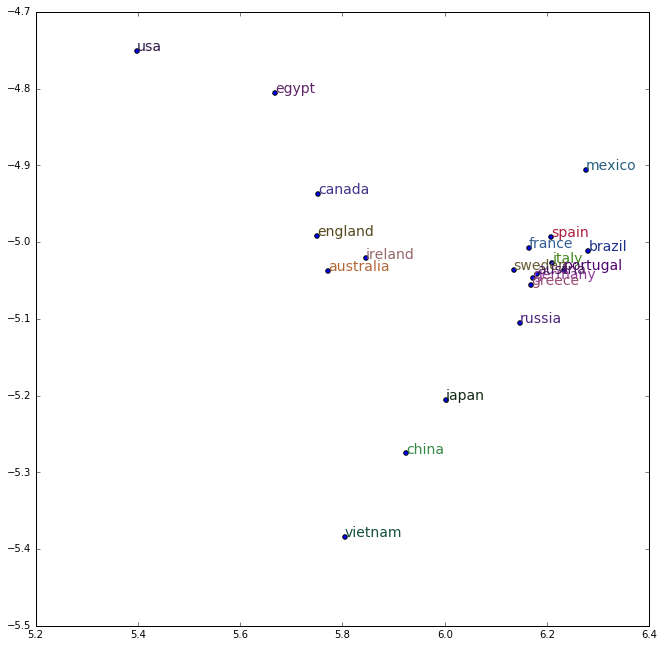

In [136]:
reload(sys) # important for labels
sys.setdefaultencoding('utf8') # important for labels

import numpy as np
import matplotlib.pyplot as plt

data = T[-len(cities):,:]
labels = cities

plt.figure(figsize=(11,11))
plt.scatter(data[:, 0], data[:, 1])
for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.text(x,y,label, color=np.random.rand(3)*0.7,
                 fontsize=14)
plt.show()

20